# Introduction

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for 
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation. 

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner! 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

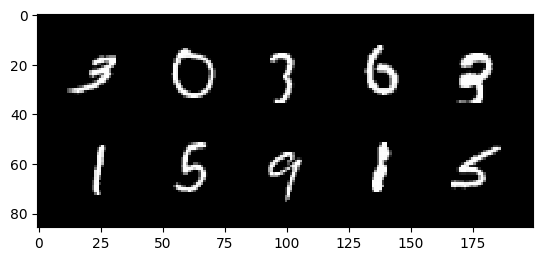

In [5]:
visualize_images(train_dataloader)

In [6]:
class CNN(nn.Module): 
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
              
        # fully connected layer, output 10 classes   
        self.out = nn.Linear(1568, 10)    
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.out(x)
        return x   
        

In [7]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
losses = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=1.3424238855555906
Epoch 1: Loss=0.4347091372740471
Epoch 2: Loss=0.27281367273653967
Epoch 3: Loss=0.2040534150802483
Epoch 4: Loss=0.17384801981812817
Epoch 5: Loss=0.14725201412782832
Epoch 6: Loss=0.13151269418708347
Epoch 7: Loss=0.11933324044033633
Epoch 8: Loss=0.109466893314305
Epoch 9: Loss=0.10127120073569024
Test set: Avg. loss: 0.0916, Accuracy: 9728/10000 (97%)


(0.09164995613098144, tensor(97.2800, device='cuda:0'))

## CIFAR10

In [8]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


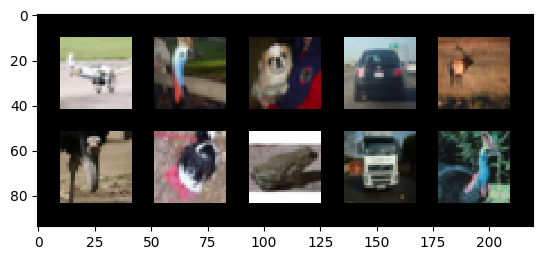

In [9]:
visualize_images(train_dataloader)

In [10]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[1024, 3, 32, 32] to have 1 channels, but got 3 channels instead

The above failed! Why? Make modifications to the model and perform the same training loop.

In [11]:
class CifarCNN(nn.Module): 
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
              
        # fully connected layer, output 10 classes   
        self.out = nn.Linear(2048, 10)    
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.out(x)
        return x   

cnn_cifar = CifarCNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn_cifar.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn_cifar, 
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn_cifar, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=2.236043555395944
Epoch 1: Loss=2.123767901440056
Epoch 2: Loss=2.00022139354628
Epoch 3: Loss=1.92256291301883
Epoch 4: Loss=1.841679531700757
Epoch 5: Loss=1.7267791932942915
Epoch 6: Loss=1.6641074370364755
Epoch 7: Loss=1.615259282442988
Epoch 8: Loss=1.5763658017528301
Epoch 9: Loss=1.5407379014151437
Test set: Avg. loss: 1.5569, Accuracy: 4450/10000 (44%)


(1.55694384765625, tensor(44.5000, device='cuda:0'))

**Takeaways**: CIfar10 is a more complex dataset than MNIST; the images are larger and RGB, the model is larger and a simple training scheme returns very bad results! How can we change this?

## Validation set

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in. 

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [12]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

print(train_dataset)

# Split the training set into training + validation. 
# How many samples does the training set have?
print(f"The training set has {len(train_dataset)} samples.")

# Split the dataset into ?????-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset, 
    lengths=[50000, 10000], 
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()
The training set has 60000 samples.


In [13]:
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

Modify the fit function to also use a validation set

In [14]:
from typing import Optional

def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

In [15]:
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

train_losses, valid_losses, valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=1.6152, Validation Loss=0.8601, Validation acc=71.2300
Epoch 1: Train Loss=0.5424, Validation Loss=0.4212, Validation acc=86.9500
Epoch 2: Train Loss=0.3194, Validation Loss=0.2713, Validation acc=92.0300
Epoch 3: Train Loss=0.2408, Validation Loss=0.2229, Validation acc=93.5900
Epoch 4: Train Loss=0.1993, Validation Loss=0.1935, Validation acc=94.4300
Epoch 5: Train Loss=0.1707, Validation Loss=0.1684, Validation acc=95.1600
Epoch 6: Train Loss=0.1516, Validation Loss=0.1515, Validation acc=95.6800
Epoch 7: Train Loss=0.1365, Validation Loss=0.1358, Validation acc=95.9400
Epoch 8: Train Loss=0.1227, Validation Loss=0.1285, Validation acc=96.1200
Epoch 9: Train Loss=0.1149, Validation Loss=0.1225, Validation acc=96.5000
Test set: Avg. loss: 0.1039, Accuracy: 9686/10000 (97%)


(0.10386053390502929, tensor(96.8600, device='cuda:0'))

## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

Epoch 0: Train Loss=2.2937, Validation Loss=2.2909, Validation acc=11.0300
Epoch 1: Train Loss=2.2890, Validation Loss=2.2863, Validation acc=14.3700
Epoch 2: Train Loss=2.2844, Validation Loss=2.2816, Validation acc=18.4100
Epoch 3: Train Loss=2.2797, Validation Loss=2.2769, Validation acc=21.8500
Epoch 4: Train Loss=2.2750, Validation Loss=2.2720, Validation acc=24.5500
Epoch 5: Train Loss=2.2701, Validation Loss=2.2670, Validation acc=26.9500
Epoch 6: Train Loss=2.2651, Validation Loss=2.2619, Validation acc=29.4500
Epoch 7: Train Loss=2.2599, Validation Loss=2.2565, Validation acc=32.7700
Epoch 8: Train Loss=2.2544, Validation Loss=2.2508, Validation acc=36.8000
Epoch 9: Train Loss=2.2486, Validation Loss=2.2449, Validation acc=40.8300
Test set: Avg. loss: 2.2450, Accuracy: 3983/10000 (40%)


Text(0, 0.5, 'Train loss')

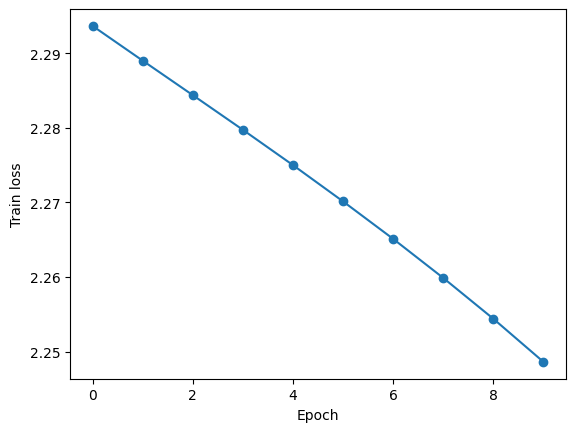

In [16]:
cnn = CNN().to(DEVICE)

optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)

train_losses, valid_losses, valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla \mathcal{L}\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla \mathcal{L}\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations 
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



Epoch 0: Train Loss=2.2957, Validation Loss=2.2779, Validation acc=24.5400
Epoch 1: Train Loss=2.2589, Validation Loss=2.2333, Validation acc=48.3800
Epoch 2: Train Loss=2.1983, Validation Loss=2.1491, Validation acc=62.8300
Epoch 3: Train Loss=2.0707, Validation Loss=1.9573, Validation acc=70.1000
Epoch 4: Train Loss=1.7651, Validation Loss=1.5069, Validation acc=74.9300
Epoch 5: Train Loss=1.2087, Validation Loss=0.9337, Validation acc=79.2600
Epoch 6: Train Loss=0.7738, Validation Loss=0.6616, Validation acc=82.4800
Epoch 7: Train Loss=0.5893, Validation Loss=0.5450, Validation acc=85.0500
Epoch 8: Train Loss=0.5015, Validation Loss=0.4826, Validation acc=86.4000
Epoch 9: Train Loss=0.4515, Validation Loss=0.4429, Validation acc=87.3100
Test set: Avg. loss: 0.4176, Accuracy: 8838/10000 (88%)


Text(0, 0.5, 'Train loss')

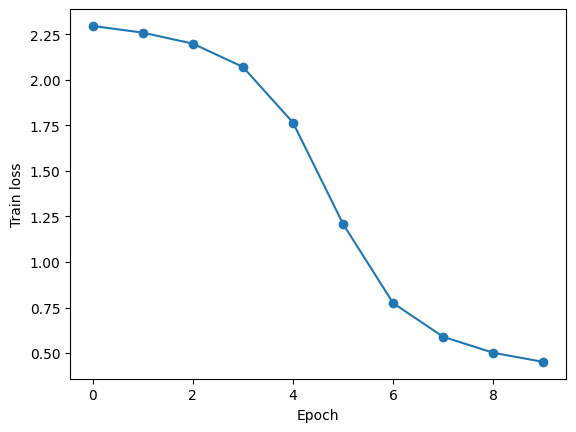

In [17]:
cnn = CNN().to(DEVICE)

optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

## Hyperparameters: Learning rate and batch size

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perfrom a grid search; define a list of choices for each hyperparameter and search over all combinations.

In [18]:
# Perform a grid search over 2 values of learning rate and 2 values of Batch size.

from itertools import product

LR_GRID = [0.01, 0.1]
BS_GRID = [256, 512]


grid = list(product(LR_GRID, BS_GRID))

models = {}
for index, (lr, bs) in enumerate(grid):

    train_dataloader = DataLoader(
        dataset=train_dataset, 
        batch_size=bs,
        shuffle=True, 
        num_workers=2)

    cnn = CNN().to(DEVICE)

    optimizer = torch.optim.SGD(cnn.parameters(), lr=lr)

    train_losses, valid_losses, valid_accs = fit(
        model=cnn, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer,
        epochs=10,
        device=DEVICE
    )

    print(f"%"*100)
    print(f"Trial {index}[lr={lr}, bs={bs}]: Validation accuracy = {valid_accs[-1]:.4f}")
    print(f"%"*100)

    models[index] = cnn

Epoch 0: Train Loss=2.2557, Validation Loss=2.1517, Validation acc=57.3000
Epoch 1: Train Loss=1.4546, Validation Loss=0.7003, Validation acc=79.4700
Epoch 2: Train Loss=0.5120, Validation Loss=0.4277, Validation acc=87.7700
Epoch 3: Train Loss=0.3862, Validation Loss=0.3904, Validation acc=88.2100
Epoch 4: Train Loss=0.3368, Validation Loss=0.3641, Validation acc=89.2300
Epoch 5: Train Loss=0.3086, Validation Loss=0.3335, Validation acc=89.7700
Epoch 6: Train Loss=0.2839, Validation Loss=0.3126, Validation acc=90.4400
Epoch 7: Train Loss=0.2625, Validation Loss=0.3006, Validation acc=90.3900
Epoch 8: Train Loss=0.2447, Validation Loss=0.2616, Validation acc=91.9200
Epoch 9: Train Loss=0.2288, Validation Loss=0.2548, Validation acc=92.4900
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Trial 0[lr=0.01, bs=256]: Validation accuracy = 92.4900
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [19]:
# Evaluate the performance on the test set with the best model!
predict(model=models[3], test_dataloader=test_dataloader, device=DEVICE)


Test set: Avg. loss: 0.0671, Accuracy: 9800/10000 (98%)


(0.06706104888916016, tensor(98., device='cuda:0'))